# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [3]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [4]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,T,T10,TD,U,VV,WW,gasPower,dwelling,hour,dayofweek
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22,185.730438,0.0,243.831944,444.333333,8.236250,12.023750,7.388889,1005.554169,30.708333,1.112500,...,9.236111,8.973611,8.283333,93.319444,9911.805583,54.069444,0.256246,All dwellings,0,2
2017-02-23,173.374907,0.0,239.148194,265.916667,11.608438,17.165569,7.612500,995.103327,24.312500,0.461319,...,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,0.485713,All dwellings,0,3
2017-02-24,246.992340,0.0,278.093543,45.766667,5.032826,7.413604,4.665972,1011.765422,107.562499,0.054306,...,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,0.276830,All dwellings,0,4
2017-02-25,150.144606,0.0,202.265418,14.750000,6.502271,9.496715,6.166667,1016.465144,49.312501,0.002083,...,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.017166,All dwellings,0,5
2017-02-26,679.171475,0.0,208.350207,82.633334,7.540049,11.129507,7.694444,1008.878202,24.770834,0.098611,...,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,0.503001,All dwellings,0,6


Saving heatmap


<Figure size 432x288 with 0 Axes>

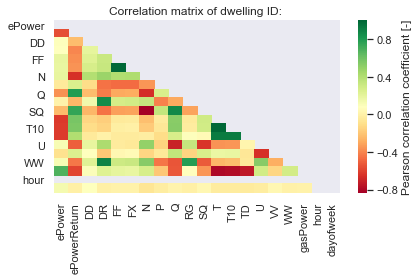

In [5]:
fig = create_corr_matrix(df, '', False)

# Select data to use

Saving heatmap
Len of data:  278


<Figure size 432x288 with 0 Axes>

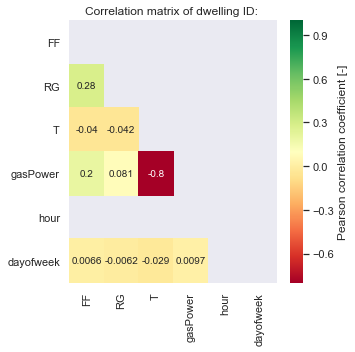

In [6]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

(array([736389., 736420., 736450., 736481., 736511., 736542., 736573.,
        736603., 736634., 736664.]), <a list of 10 Text xticklabel objects>)

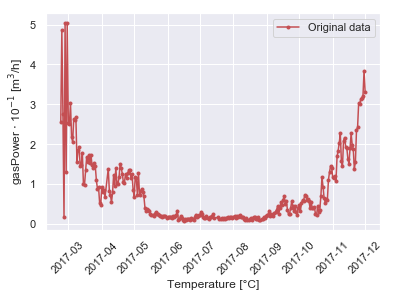

In [7]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

## datetime info to categorical

In [8]:
#columns_to_cat = ['year', 'month', 'day', 'hour', 'dayofweek', 'season']
columns_to_cat = ['hour', 'dayofweek']
data[columns_to_cat] = data[columns_to_cat].astype('category') # change datetypes to category

data = pd.get_dummies(data, columns=columns_to_cat) # One hot encoding the categories
data.head()

,FF,RG,T,gasPower,hour_0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,
2017-02-22,8.236250,1.112500,9.236111,2.562459,1,0,0,1,0,0,0,0
2017-02-23,11.608438,0.461319,8.590000,4.857127,1,0,0,0,1,0,0,0
2017-02-24,5.032826,0.054306,4.746250,2.768300,1,0,0,0,0,1,0,0
2017-02-25,6.502271,0.002083,5.606806,0.171661,1,0,0,0,0,0,1,0
2017-02-26,7.540049,0.098611,8.688750,5.030009,1,0,0,0,0,0,0,1


# Train test split and scale

In [9]:
from sklearn.model_selection import train_test_split
# Nobody turns on their heating when T > 19?, so deselect this data
#data = data[data['T'] < 19]

#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = data.drop(['gasPower'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

test_size = 0.5

split_index = int(data.shape[0]*test_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]
        
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

print((X_train.shape, y_train.shape))

print((X_test.shape, y_test.shape))

X columns: ['FF', 'RG', 'T', 'hour_0', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6']
((139, 11), (139, 1))
((139, 11), (139, 1))


# Multivariate linear regression model

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6703222946386069

# Get prediction results

In [11]:
y_pred = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
print(len(y_true), len(x))

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

139 139


In [12]:
perc = (y_true - y_pred)/y_pred
perc.shape

(139, 1)

FINISHED


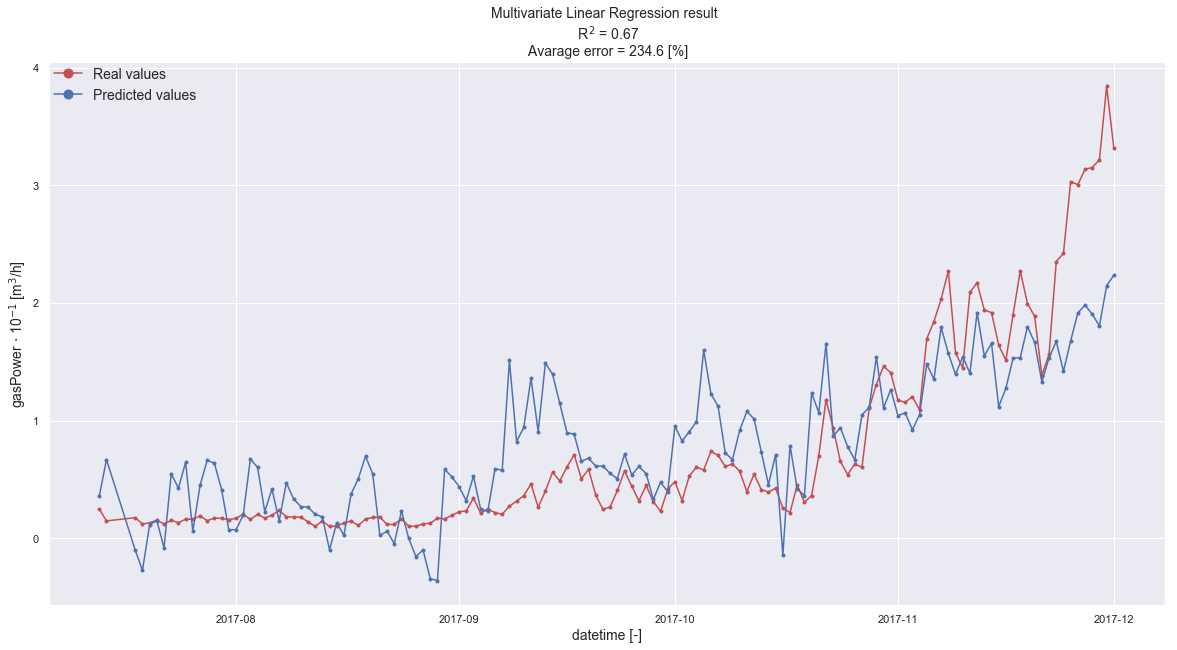

In [13]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='r', label='Real values')
plt.plot(x.index, y_pred, '.-', color='b', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

r2 = model.score(X_test, y_test)
perc = np.abs(((y_true - y_pred) / y_pred)*100).mean()

plt.title('Multivariate Linear Regression result \n R$^2$ = %.2f \n Avarage error = %.1f [%%]' % (r2, perc), fontsize = 14)

plt.savefig('MVR result daily.png', dpi=1200)
print('FINISHED')